# Project 2. Limited time training

 In project 2, you're going to improve your network under the limitation of time, specifically 10 minutes. You can borrow any structure that you consider viable, but pretrained models are **NOT allowed**.

**Hint**: Most of the popular networks can't converge in 10 minutes, so if you decide to borrow any, you'd have to trim the network a little to fit into the time frame.

## 1. Preparation

This project is time limited, we need to make sure that your hardwares are exactly the same, try the following code, if you see 'GPU correct, proceed.', you can continue the project, otherwise, click the dropdown at the upper right corner besides the status bar (RAM, Disk), and go to 'Manage sessions', and terminate the current session, then reconnect, and try the code again, repeat until you see the right message.

In [11]:
!if [ $(nvidia-smi | grep Tesla | tr -s " " | cut -d' ' -f4) == 'T4' ]; then echo "GPU correct, proceed."; else echo "GPU incorrect, please terminate this session and reconnect again."; fi

GPU correct, proceed.


## 2. Before training

For dataset, we continue to use CIFAR10, in this part, you can configure all of your settings, including data augmentation, model structure, optimizer etc., but don't put any major calculation part in.

### 2.1 Dataset

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_train = torchvision.datasets.CIFAR10("CIFAR10", train=True, transform=transform_train, download=True)
cifar10_test = torchvision.datasets.CIFAR10("CIFAR10", train=False, transform=transform_test, download=True)

train_loader = DataLoader(cifar10_train, batch_size=512, shuffle=True,
                         num_workers=4, pin_memory=True)
test_loader = DataLoader(cifar10_test, batch_size=1000, shuffle=False,
                        num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 2.2 Model

**Hint**: Even though pretrained models are not allowed in your final version, you can use pretrained models to determine how well the structure CAN perform and use this as part of your analysis as to determining network structure.

**Model definition**

In [13]:
import torch
import torch.nn as nn

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2)
        )

        self.residual = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64),  # depthwise
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1),  # pointwise
            nn.BatchNorm2d(64)
        )
        self.residual_act = nn.ReLU(inplace=True)

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        identity = x
        res_out = self.residual(x)
        x = self.residual_act(res_out + identity)

        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

net = MyNet().cuda()

**Analysis tools**

In [14]:
def testset_precision(net, testset):
    net.eval()
    dl = DataLoader(testset, batch_size=512)
    total_count = 0
    total_correct = 0
    for data in dl:
        inputs = data[0].cuda()
        targets = data[1].cuda()
        outputs = net(inputs)
        predicted_labels = outputs.argmax(dim=1)
        comparison = predicted_labels == targets
        total_count += predicted_labels.size(0)
        total_correct += comparison.sum()
    net.train()

    return int(total_correct) / int(total_count)

print(f'Inital precision: {testset_precision(net, cifar10_test)}')

from IPython import display
import matplotlib.pyplot as plt
import time

class DrawingBoard:
    def __init__(self, names, time_slot=60):
        self.start_time = time.time()
        self.time_slot = time_slot
        self.annotations = []
        self.data = {}
        for name in names:
            self.data[name] = []

    def update(self, data_dict):
        for key in data_dict:
            self.data[key].append(data_dict[key])
        current_time = time.time() - self.start_time
        idx = len(self.data[key]) -1
        if len(self.annotations) == 0:
            if current_time > self.time_slot:
                self.annotations.append((idx, current_time))
        elif current_time - (self.annotations[-1][1]//self.time_slot)*self.time_slot > self.time_slot:
            self.annotations.append((idx, current_time))

    def draw(self):
        all_keys = list(self.data.keys())
        fig, ax = plt.subplots(nrows=1, ncols=len(all_keys))
        fig.set_figwidth(20)
        for idx in range(len(all_keys)):
            ax[idx].plot(self.data[all_keys[idx]])
            ax[idx].set_title(all_keys[idx])
            for an in self.annotations:
                ax[idx].annotate(f'{int(an[1])}s', xy=(an[0], self.data[all_keys[idx]][an[0]]),
                    xytext=(0, -40), textcoords="offset points",
                    va="center", ha="left",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
        display.clear_output(wait=True)
        plt.show()

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def get_confusion_matrix(net, dataloader):
    net.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data[0].cuda(), data[1].cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    return cm

def analyze_misclassifications(net, dataloader, class_names):
    net.eval()
    misclassified = {i: {j: 0 for j in range(len(class_names)) if j != i} for i in range(len(class_names))}

    misclassified_examples = []

    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data[0].cuda(), data[1].cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)

            mask = (predicted != targets)
            if mask.sum() > 0:
                wrong_preds = predicted[mask].cpu().numpy()
                wrong_targets = targets[mask].cpu().numpy()
                wrong_inputs = inputs[mask].cpu()

                for true_label, pred_label in zip(wrong_targets, wrong_preds):
                    misclassified[true_label][pred_label] += 1

                for i in range(min(5, len(wrong_targets))):
                    misclassified_examples.append((
                        wrong_inputs[i],
                        wrong_targets[i],
                        wrong_preds[i]
                    ))
                    if len(misclassified_examples) >= 20:
                        break

            if len(misclassified_examples) >= 20:
                break

    most_common_errors = {}
    for true_class in range(len(class_names)):
        errors = misclassified[true_class]
        if errors:
            most_common_wrong_class = max(errors.items(), key=lambda x: x[1])
            most_common_errors[true_class] = most_common_wrong_class

    return misclassified, most_common_errors, misclassified_examples

def plot_misclassified_examples(examples, class_names):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    def denormalize(x):
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        x = x.numpy().transpose((1, 2, 0))
        x = std * x + mean
        x = np.clip(x, 0, 1)
        return x

    for i, (img, true_label, pred_label) in enumerate(examples[:20]):
        img = denormalize(img)
        axes[i].imshow(img)
        axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
def compare_models(baseline_net, trained_net, dataloader, class_names):
    device = next(trained_net.parameters()).device
    baseline_net = baseline_net.to(device)
    baseline_cm = get_confusion_matrix(baseline_net, dataloader)
    trained_cm = get_confusion_matrix(trained_net, dataloader)

    plot_confusion_matrix(baseline_cm, class_names, title='Baseline Model Confusion Matrix')
    plot_confusion_matrix(trained_cm, class_names, title='Trained Model Confusion Matrix')

    baseline_misclassified, baseline_errors, baseline_examples = analyze_misclassifications(
        baseline_net, dataloader, class_names)
    trained_misclassified, trained_errors, trained_examples = analyze_misclassifications(
        trained_net, dataloader, class_names)

    print("Most common misclassifications of the baseline model:")
    for true_class, (wrong_class, count) in baseline_errors.items():
        print(f"{class_names[true_class]} Most common misclassifications {class_names[wrong_class]}, Count: {count}")

    print("\nMost common misclassifications of the trained model:")
    for true_class, (wrong_class, count) in trained_errors.items():
        print(f"{class_names[true_class]} Most common misclassifications {class_names[wrong_class]}, Count: {count}")

    print("\nExamples of baseline misclassifications:")
    plot_misclassified_examples(baseline_examples, class_names)

    print("\nExamples of trained misclassifications:")
    plot_misclassified_examples(trained_examples, class_names)

    baseline_accuracy_per_class = baseline_cm.diagonal() / baseline_cm.sum(axis=1)
    trained_accuracy_per_class = trained_cm.diagonal() / trained_cm.sum(axis=1)

    plt.figure(figsize=(12, 6))
    x = np.arange(len(class_names))
    width = 0.35

    plt.bar(x - width/2, baseline_accuracy_per_class, width, label='Baseline Model')
    plt.bar(x + width/2, trained_accuracy_per_class, width, label='Trained Model')

    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Per-class Accuracy Comparison')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
"""
print("Analyze the misclassification of the benchmark model...")
baseline_net = net
baseline_cm = get_confusion_matrix(baseline_net, test_loader)
plot_confusion_matrix(baseline_cm, classes, title='Baseline Model Confusion Matrix')

baseline_misclassified, baseline_errors, baseline_examples = analyze_misclassifications(
    baseline_net, test_loader, classes)

print("Most common misclassifications of the baseline model:")
for true_class, (wrong_class, count) in baseline_errors.items():
    print(f"{classes[true_class]} Most common misclassifications {classes[wrong_class]}, Count: {count}")

print("\nExamples of baseline misclassifications:")
plot_misclassified_examples(baseline_examples, classes)
baseline_net_copy = type(net)()
baseline_net_copy.load_state_dict(baseline_net.state_dict())
baseline_net_copy = baseline_net_copy.cuda()
"""

Inital precision: 0.1033


'\nprint("Analyze the misclassification of the benchmark model...")\nbaseline_net = net\nbaseline_cm = get_confusion_matrix(baseline_net, test_loader)\nplot_confusion_matrix(baseline_cm, classes, title=\'Baseline Model Confusion Matrix\')\n\nbaseline_misclassified, baseline_errors, baseline_examples = analyze_misclassifications(\n    baseline_net, test_loader, classes)\n\nprint("Most common misclassifications of the baseline model:")\nfor true_class, (wrong_class, count) in baseline_errors.items():\n    print(f"{classes[true_class]} Most common misclassifications {classes[wrong_class]}, Count: {count}")\n\nprint("\nExamples of baseline misclassifications:")\nplot_misclassified_examples(baseline_examples, classes)\nbaseline_net_copy = type(net)()\nbaseline_net_copy.load_state_dict(baseline_net.state_dict())\nbaseline_net_copy = baseline_net_copy.cuda()\n'

In [ ]:
# modify as you need
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                     momentum=0.95, weight_decay=1e-4)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,
    steps_per_epoch=len(train_loader),
    epochs=20,
    cycle_momentum=True,
    pct_start=0.3
)
criterion = nn.CrossEntropyLoss()

## 3. Start Training

This is the training part, take advantage of everything you know. In addition to the tips last time, you can also consider data augmentation, short cut structure in ResNet etc.

Basically at this point, nothing is limited except time and pretrained models.

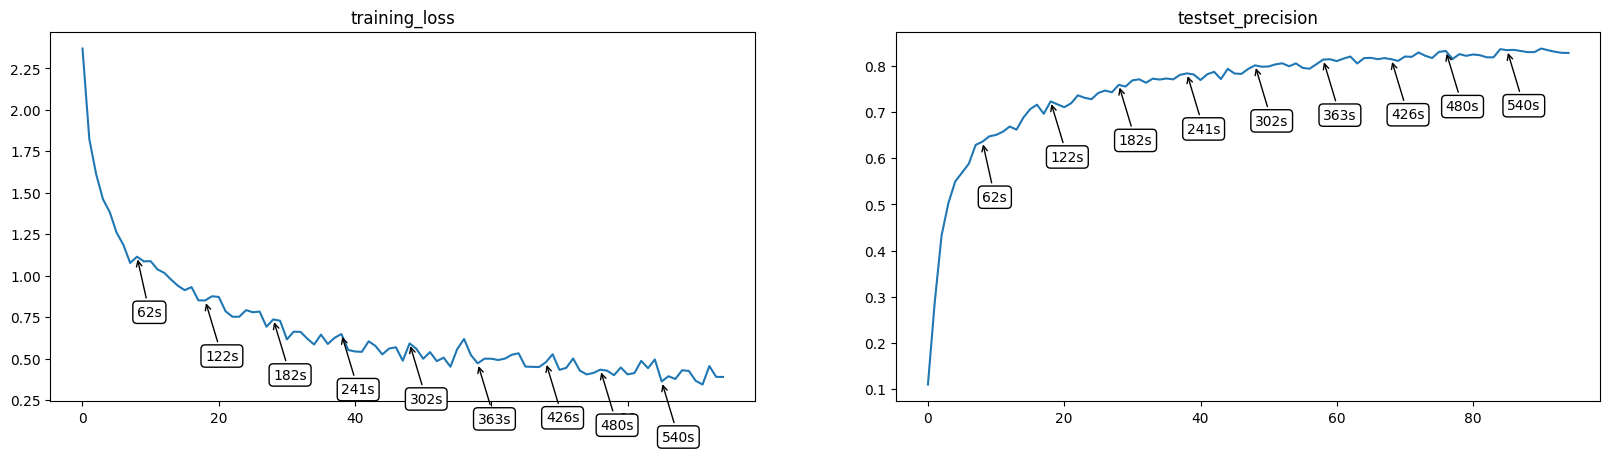

<ipython-input-16-7bf6de4ef36a>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


NotImplementedError: Time's up

In [16]:
# modify as you need
import time
import signal
import torch


scaler = torch.amp.GradScaler('cuda')

class TimeLimitation:
    def __init__(self, limit):
        self.limit = limit

    def __enter__(self):
        def handler(signum, frame):
            raise NotImplementedError('Time\'s up')
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(self.limit)

    def __exit__(self, exc_type, exc_val, exc_tb):
        signal.alarm(0)


with TimeLimitation(600): # don't forget the indentation
    print('start training')
    db = DrawingBoard(['training_loss', 'testset_precision'], time_slot=60)

    initial_precision = testset_precision(net, cifar10_test)
    print(f'Initial precision: {initial_precision:.4f}')

    best_precision = initial_precision

    for epoch in range(20):
        running_loss = 0.0
        print('epoch: ',epoch)
        for iter, data in enumerate(train_loader):
            inputs, targets = data[0].cuda(), data[1].cuda()

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = net(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            if iter % 20 == 0:
                current_precision = testset_precision(net, cifar10_test)

                db.update({'training_loss':loss.item(), 'testset_precision': current_precision})
                db.draw()

                if current_precision > best_precision:
                    best_precision = current_precision
                    torch.save(net.state_dict(), 'best_model.pth')

                running_loss = 0.0
        scheduler.step()


    print('finished')

In [ ]:
"""
print("\nAnalyze the misclassification of the trained model...")
trained_net = net
trained_net = trained_net.cuda()
trained_cm = get_confusion_matrix(trained_net, test_loader)
#plot_confusion_matrix(trained_cm, classes, title='Trained Model Confusion Matrix')

trained_misclassified, trained_errors, trained_examples = analyze_misclassifications(
    trained_net, test_loader, classes)

print("Most common misclassifications of the trained model:")
for true_class, (wrong_class, count) in trained_errors.items():
    print(f"{classes[true_class]} Most common misclassifications {classes[wrong_class]}, Count: {count}")

print("\nExamples of misclassifications by the trained model:")
#plot_misclassified_examples(trained_examples, classes)

print("\nComparing model performance before and after training...")

baseline_net_copy.load_state_dict(baseline_net.state_dict())

compare_models(baseline_net_copy, trained_net, test_loader, classes)
'''

# Marking Scheme

*   Code implementation: 30%


> * Successfully run through the whole project: 10%
> * Code implementation quality: 20% (including performance)

*   PDF report: 50%

> * Overview, introduction to the network structure etc.: 10%
> * Analysis and improvements: 40%

*   Presentation: 20%

> * Overall demonstration: 10%
> * Unfolding analysis: 10%